In [1]:
import datetime as dt
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

from aquabyte.data_loader import KeypointsDataset, NormalizeCentered2D, ToTensor, BODY_PARTS
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from copy import copy

pd.set_option('display.max_rows', 500)

<h1> Prepare GTSF dataset </h1>

In [2]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints -> 'leftCrop' is not null
    and b.keypoints -> 'rightCrop' is not null
    and b.is_qa = false 
    and b.captured_at < '2019-09-19';
"""
df = rds_access_utils.extract_from_database(query)

In [3]:
blacklisted_keypoint_annotation_ids = [
    606484, 
    635806, 
    637801, 
    508773, 
    640493, 
    639409, 
    648536, 
    507003,
    706002,
    507000,
    709298,
    714073,
    719239
]

df = df[~df.id.isin(blacklisted_keypoint_annotation_ids)]

def get_world_keypoints(row):
    return pixel2world(row.keypoints['leftCrop'], row.keypoints['rightCrop'], row.camera_metadata)
    
def is_well_behaved(wkps, cutoff_depth=10.0):
    if any([abs(wkp[1]) > cutoff_depth for wkp in wkps.values()]):
        return False
    return True

df['world_keypoints'] = df.apply(
    lambda x: get_world_keypoints(x), axis=1
)

is_well_behaved_mask = df.world_keypoints.apply(lambda x: is_well_behaved(x))
df = df[is_well_behaved_mask]

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)


In [6]:
class KeypointsDataset(Dataset):
    """Keypoints dataset
    This is the base version of the dataset that is used to map 3D keypoints to a
    biomass estimate. The label is the weight, and the input is the 3D workd keypoints
    obtained during triangulation
    """

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        if self.transform:
            input_sample = {
                'keypoints': row.keypoints,
                'cm': row.camera_metadata,
                'stereo_pair_id': row.id,
            }
            if 'length' in dict(row).keys():
                input_sample['label'] = 1e5 * (row.weight / (row.length**3))
            sample = self.transform(input_sample)
            return sample

        world_keypoints = row.world_keypoints
        length = row.length

        sample = {'kp_input': world_keypoints, 'label': length, 'stereo_pair_id': row.id}

        return sample
    
class NormalizedStabilityTransform(object):
    """
        Transforms world keypoints into a more stable coordinate system - this will lead to better
        training / convergene
    """
    
    def __call__(self, sample):
        modified_kps, label, stereo_pair_id, cm = \
            sample['modified_kps'], sample['label'], sample['stereo_pair_id'], sample['cm']
        modified_wkps = pixel2world(modified_kps['leftCrop'], modified_kps['rightCrop'], cm)
        stabilized_coordinates = {}
        for bp in BODY_PARTS:
            wkp = modified_wkps[bp]
            stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]
            stabilized_coordinates[bp] = stabilized_kp_info
            
        normalized_label = label
        
        transformed_sample = {
            'kp_input': stabilized_coordinates,
            'label': normalized_label,
            'stereo_pair_id': stereo_pair_id,
            'single_point_inference': sample.get('single_point_inference')
        }
        
        return transformed_sample

In [7]:
gtsf_fish_identifiers = list(df.fish_id.unique())
train_size = int(0.8 * len(gtsf_fish_identifiers))
fish_ids = random.sample(gtsf_fish_identifiers, train_size)
date_mask = (df.captured_at < '2019-09-10')
train_mask = date_mask & df.fish_id.isin(fish_ids)
test_mask = date_mask & ~df.fish_id.isin(fish_ids)

In [8]:
df['length'] = df.data.apply(lambda x: x['lengthMms'])

In [9]:
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

train_dataset = KeypointsDataset(df[train_mask], transform=transforms.Compose([
                                                  NormalizeCentered2D(lo=0.3, hi=2.0, jitter=10),
                                                  NormalizedStabilityTransform(),
                                                  ToTensor()
                                              ]))

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=1, worker_init_fn=worker_init_fn)

In [10]:
test_dataset = KeypointsDataset(df[test_mask], transform=transforms.Compose([
                                                      NormalizeCentered2D(lo=0.3, hi=2.0, jitter=10),
                                                      NormalizedStabilityTransform(),
                                                      ToTensor()
                                                  ]))

test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True, num_workers=1, worker_init_fn=worker_init_fn)

In [11]:
# TODO: Define your network architecture here
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x
        



In [12]:
# establish output directory where model .pb files will be written
# dt_now = dt.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
# output_base = '/root/data/alok/biomass_estimation/results/neural_network'
# output_dir = os.path.join(output_base, dt_now)
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# instantiate neural network
network = Network()
epochs = 1000
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

# track train and test losses
train_losses, test_losses = [], []

for epoch in range(epochs):
    np.random.seed(epoch)
    running_loss = 0.0
    for i, data_batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        X_batch, y_batch, kpid_batch = \
            data_batch['kp_input'], data_batch['label'], data_batch['stereo_pair_id']
        y_pred = network(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i > 0 and i % 100 == 0:
            print(running_loss / i)
            
    # run on test set
    else:
        test_running_loss = 0.0
        with torch.no_grad():
            for i, data_batch in enumerate(test_dataloader):
                X_batch, y_batch, kpid_batch = \
                    data_batch['kp_input'], data_batch['label'], data_batch['stereo_pair_id']
                y_pred = network(X_batch)
                loss = criterion(y_pred, y_batch)
                test_running_loss += loss.item()

    train_loss_for_epoch = running_loss / len(train_dataloader)
    test_loss_for_epoch = test_running_loss / len(test_dataloader)
    train_losses.append(train_loss_for_epoch)
    test_losses.append(test_loss_for_epoch)
    
#     # save current state of network
#     f_name = 'nn_epoch_{}.pb'.format(str(epoch).zfill(3))
#     f_path = os.path.join(output_dir, f_name)
#     torch.save(network, f_path)
    
    # print current loss values
    print('-'*20)
    print('Epoch: {}'.format(epoch))
    print('Train Loss: {}'.format(train_loss_for_epoch))
    print('Test Loss: {}'.format(test_loss_for_epoch))
    
    


0.9706956082582474
0.5266853783838451
0.36293977590898674
0.27878580504795536
0.2278162677511573
--------------------
Epoch: 0
Train Loss: 0.2206179553779511
Test Loss: 0.020500368490884793
0.024365622252225876
0.023981225625611842
0.023802432306110857
0.02386101512936875
0.02334518940933049
--------------------
Epoch: 1
Train Loss: 0.023257926779324513
Test Loss: 0.018815805474035094
0.02249617563560605
0.022899050805717705
0.022310214430714646
0.02200702307978645
0.02150387536548078
--------------------
Epoch: 2
Train Loss: 0.02148058162426799
Test Loss: 0.017047184123440046
0.02034397982992232
0.021221735696308315
0.020641892813146115
0.02002055161399767
0.0200826035477221
--------------------
Epoch: 3
Train Loss: 0.020026679411458578
Test Loss: 0.015091495840836352
0.019483362324535847
0.020461486410349606
0.019719113015259304
0.019341832930222153
0.01897416103631258
--------------------
Epoch: 4
Train Loss: 0.018933119980481715
Test Loss: 0.015239934719855262
0.019575035218149423


0.007886921856552362
0.008091201796196401
0.008320173976011574
--------------------
Epoch: 41
Train Loss: 0.00834919253641085
Test Loss: 0.008187660453492932
0.00944314838387072
0.008812235883669927
0.008647367019051066
0.00841965881700162
0.008244795857928693
--------------------
Epoch: 42
Train Loss: 0.008219537550842383
Test Loss: 0.006576594348265746
0.007626293739303946
0.00788158054696396
0.008080063943440715
0.007894631936796941
0.00834304733807221
--------------------
Epoch: 43
Train Loss: 0.008282483697861692
Test Loss: 0.0067010693073655675
0.008355891508981585
0.008428043415769935
0.008708518059769025
0.00837152831023559
0.008251258186064661
--------------------
Epoch: 44
Train Loss: 0.00823762351880749
Test Loss: 0.007015649438182885
0.008050409124698489
0.008289461166132241
0.007929226034320891
0.008005526618799195
0.008328105300199241
--------------------
Epoch: 45
Train Loss: 0.008299525720867397
Test Loss: 0.006508098947859117
0.007868645472917705
0.009095614369725809
0

0.006639947692747228
0.007423771336907521
0.007394265943730716
0.007535739291226491
--------------------
Epoch: 82
Train Loss: 0.0074973996878335515
Test Loss: 0.006737143177730597
0.007814305613283067
0.007202237850287929
0.006926544948170583
0.006993522646953351
0.007462229170836508
--------------------
Epoch: 83
Train Loss: 0.0074089139009534625
Test Loss: 0.007075399134273284
0.009611648377031087
0.008458394575864076
0.007970877101179212
0.00764817652408965
0.007514010258717462
--------------------
Epoch: 84
Train Loss: 0.007486425103973885
Test Loss: 0.0063094485498895155
0.00667705311672762
0.007348045608960092
0.00780185833418121
0.007506252953317016
0.007448695367667824
--------------------
Epoch: 85
Train Loss: 0.007422668930380443
Test Loss: 0.006177241121914899
0.007529208257328719
0.008127037934609688
0.007711632917247092
0.0075277592465863566
0.007443477481370792
--------------------
Epoch: 86
Train Loss: 0.007413447942651276
Test Loss: 0.005997333916069539
0.0065474399598

0.007095456484239549
0.00683649807528127
0.006725237655530994
0.007359580823977013
0.00722633245238103
--------------------
Epoch: 123
Train Loss: 0.007172427403346841
Test Loss: 0.0059279058733519826
0.00725868008332327
0.008238079611910507
0.007562542560820778
0.0072981413610978055
0.007224371603690088
--------------------
Epoch: 124
Train Loss: 0.007148092610994803
Test Loss: 0.006616459400001391
0.009103769503999501
0.008101675517391414
0.007729676531938215
0.007492109024315141
0.007345937257166952
--------------------
Epoch: 125
Train Loss: 0.007270016854235176
Test Loss: 0.005809404489053326
0.006352433231659234
0.006428021426545456
0.0066637426110294955
0.007168271893169731
0.007143334539607167
--------------------
Epoch: 126
Train Loss: 0.007123778616419803
Test Loss: 0.007022712891051006
0.008545425899792463
0.007871630046283827
0.007303024627423535
0.007235718568554148
0.007152143479790539
--------------------
Epoch: 127
Train Loss: 0.007160207587042572
Test Loss: 0.007851198

0.006426763986237347
0.006321569123538211
0.006313750073313713
0.0068441573297604915
0.006840622042305768
--------------------
Epoch: 164
Train Loss: 0.006845068689489658
Test Loss: 0.0068217708705271655
0.00600638726959005
0.006194461807608604
0.006328551895761241
0.006738465104135684
0.006880901166703552
--------------------
Epoch: 165
Train Loss: 0.006815729381850989
Test Loss: 0.006362544873154887
0.007975611598230898
0.007432172400876879
0.0071442218955295785
0.006975947348983027
0.006869411527877674
--------------------
Epoch: 166
Train Loss: 0.0068727177871179025
Test Loss: 0.005547257425333156
0.00617311495472677
0.006182786459685303
0.007025767902766044
0.006771589508571196
0.006810621487209573
--------------------
Epoch: 167
Train Loss: 0.006780883671965767
Test Loss: 0.005666205415798125
0.007269414309412241
0.006786469639046118
0.006596098488662392
0.006571645402000286
0.006845909581985324
--------------------
Epoch: 168
Train Loss: 0.0067945380580996285
Test Loss: 0.005457

--------------------
Epoch: 204
Train Loss: 0.0066827368881179445
Test Loss: 0.005889845267808605
0.00923197355121374
0.007529563875868917
0.006984567961189896
0.006861662312876433
0.006688477752264589
--------------------
Epoch: 205
Train Loss: 0.006661592779094965
Test Loss: 0.005481143049007961
0.006963674661237746
0.006382200692314655
0.00644479642311732
0.006271779178932775
0.0066163858019281175
--------------------
Epoch: 206
Train Loss: 0.006629811563218034
Test Loss: 0.005505068943548565
0.0068855429627001285
0.00656968355528079
0.006963157999174048
0.006809591613709927
0.006633617959916592
--------------------
Epoch: 207
Train Loss: 0.0066174919704428395
Test Loss: 0.005922369567555524
0.005860686771338806
0.006234964045579545
0.006174798335026329
0.006747375287814066
0.006537081947550177
--------------------
Epoch: 208
Train Loss: 0.006612606327729048
Test Loss: 0.006161831839393093
0.006372502408921719
0.0071218364522792395
0.006907171958591789
0.006612617836217396
0.0067008

0.0062757556507131084
0.005949437371455133
0.006519230917328969
0.006527002792805433
--------------------
Epoch: 245
Train Loss: 0.006500693659287334
Test Loss: 0.005527545298693406
0.006640989723382518
0.005968973146518692
0.006219158297559867
0.006101419834885746
0.0064863870246335865
--------------------
Epoch: 246
Train Loss: 0.006437366211186361
Test Loss: 0.0057218162577912625
0.006774311230983585
0.0062223540182458235
0.006042679970075066
0.0061289802033570595
0.0064474361159373075
--------------------
Epoch: 247
Train Loss: 0.006468611580596582
Test Loss: 0.005428115832924007
0.006191535873804241
0.006152399182319641


KeyboardInterrupt: 

In [13]:
torch.save(network, '/root/data/alok/biomass_estimation/playground/kf_predictor.pb')


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [46]:
preds, gts = [], []
with torch.no_grad():
    for i, data_batch in enumerate(train_dataloader):
        X_batch, y_batch, kpid_batch = \
            data_batch['kp_input'], data_batch['label'], data_batch['stereo_pair_id']
        y_pred = network(X_batch)
        preds.extend(list(y_pred.numpy().flatten()))
        gts.extend(list(data_batch['label'].numpy().flatten()))


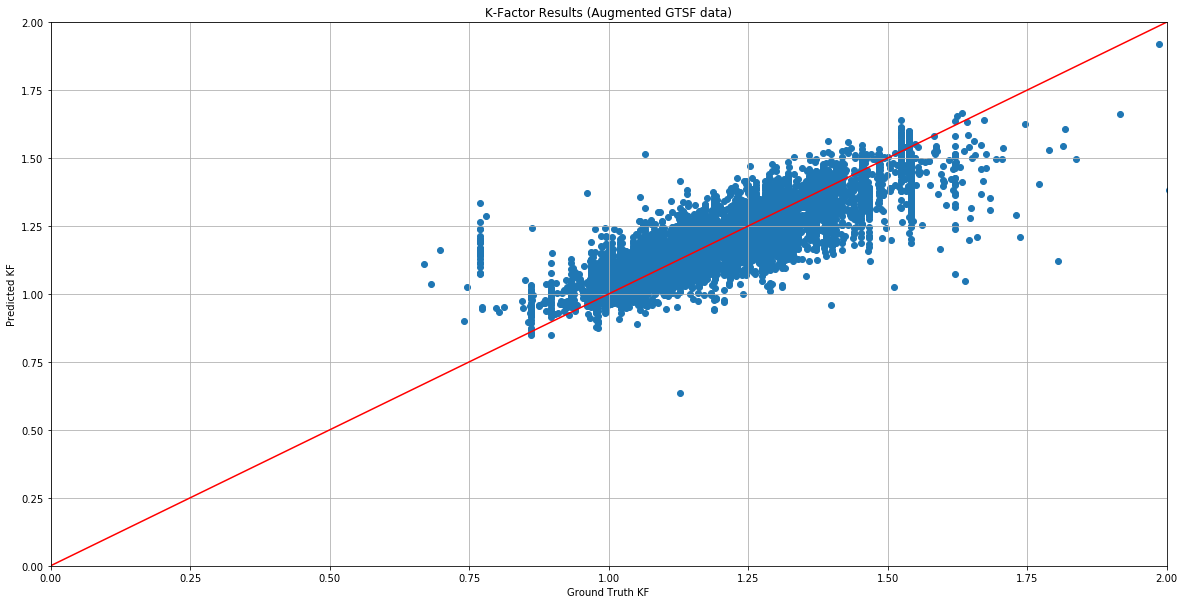

In [72]:
preds = np.array(preds)
gts = np.array(gts)
plt.figure(figsize=(20, 10))
plt.scatter(gts, preds)
plt.plot([0, 2], [0, 2], color='red')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.xlabel('Ground Truth KF')
plt.ylabel('Predicted KF')
plt.title('K-Factor Results (Augmented GTSF data)')
plt.grid()
plt.show()


In [63]:
kfs = np.arange(0.7, 1.75, 0.1)
err_pcts = []
sample_sizes = []
for idx in range(len(kfs) - 1):
    low_kf, high_kf = kfs[idx], kfs[idx + 1]
    mask = (gts > low_kf) & (gts < high_kf)
    err_pcts.append(np.mean((preds[mask] - gts[mask]) / gts[mask]))
    sample_sizes.append(mask.sum())
    

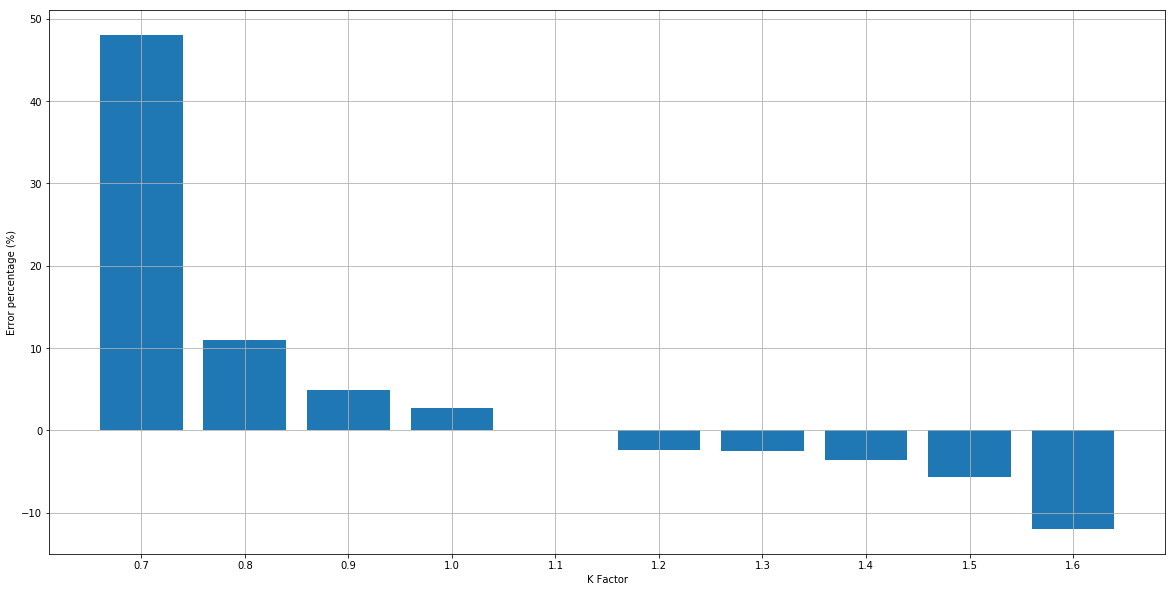

In [81]:
plt.figure(figsize=(20, 10))
plt.bar(list(range(len(err_pcts))), 100 * np.array(err_pcts))
plt.xticks(list(range(len(err_pcts))), [round(x, 2) for x in kfs])
plt.xlabel('K Factor')
plt.ylabel('Error percentage (%)')
plt.grid()
plt.show()

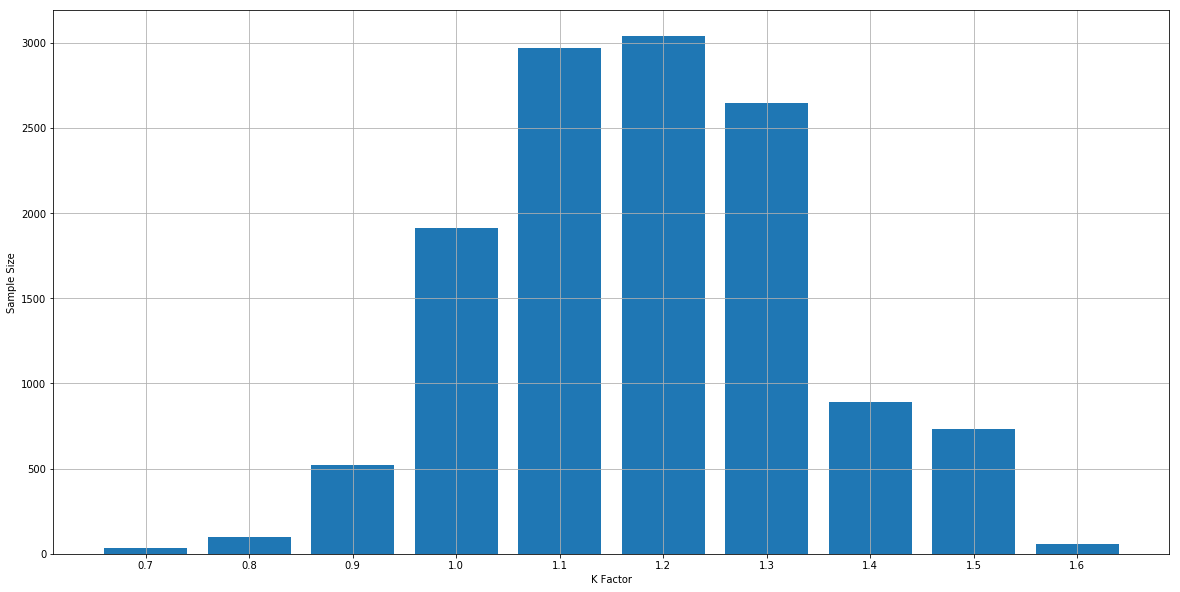

In [84]:
plt.figure(figsize=(20, 10))
plt.bar(list(range(len(sample_sizes))), sample_sizes)
plt.xticks(list(range(len(sample_sizes))), [round(x, 2) for x in kfs])
plt.xlabel('K Factor')
plt.ylabel('Sample Size')
plt.grid()
plt.show()

In [67]:
np.array(sample_sizes) / np.array(sample_sizes).sum()

array([0.00263403, 0.00743725, 0.04044004, 0.14797025, 0.23016734,
       0.23543539, 0.20522157, 0.06910443, 0.05694143, 0.00464828])

In [58]:
len(kfs), len(err_pcts)

(11, 10)

In [86]:
np.median(np.abs((np.array(preds) - np.array(gts)) / np.array(gts)))

0.03427606

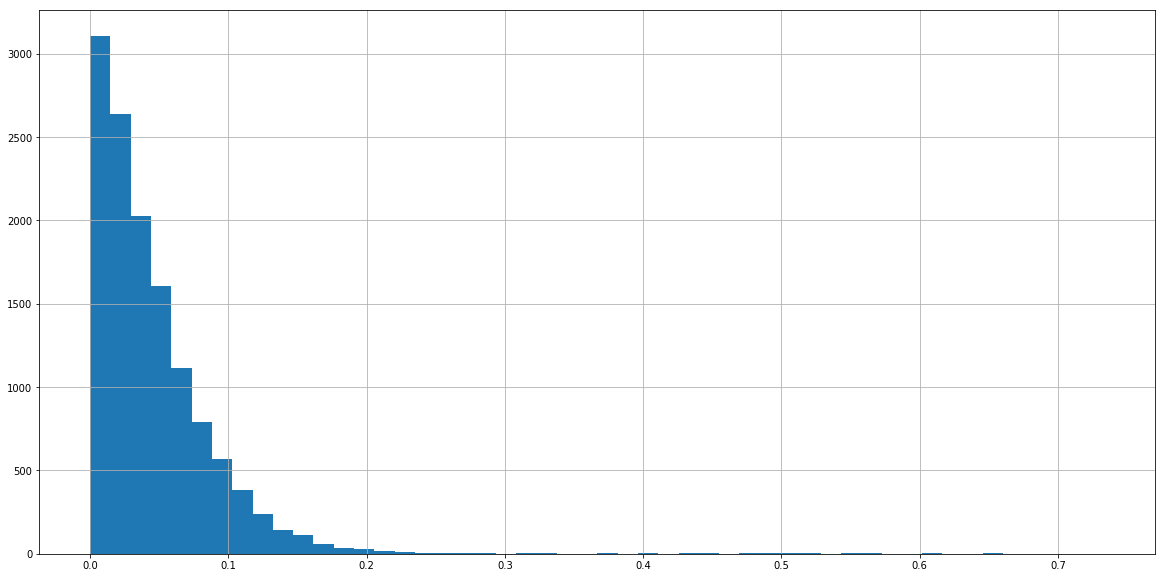

In [90]:
plt.figure(figsize=(20, 10))
plt.hist(np.abs((preds - gts) / gts), bins=50)
plt.grid()
plt.show()

In [ ]:
torch.save(network, '/root/data/alok/biomass_estimation/playground/length_predictor.pb')


In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(train_losses)), train_losses, color='blue', label='training loss')
plt.plot(range(len(test_losses)), test_losses, color='orange', label='validation loss')
plt.ylim([0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Loss value (MSE)')
plt.title('Loss curves (MSE - Adam optimizer)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
test_losses[-1]

In [ ]:
np.min(test_losses)

In [ ]:
np.min(train_losses)

In [ ]:
df[test_mask].shape